In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
plt.rcParams['figure.figsize'] = [14, 9]

import collections
from PIL import Image
from sklearn.model_selection import train_test_split
from config import TRAIN_DIR, TEST_DIR, DATA_DIR

train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
sample_submission_df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

In [38]:
test = np.random.rand(25000, 2048)
train = np.random.rand(7000, 2048)



In [39]:
from scipy.spatial.distance import cdist

cdist(test, train, metric='euclidean')

array([[18.52608846, 18.53129352, 18.27239701, ..., 18.53267682,
        18.55756615, 18.36263603],
       [18.40369371, 18.78839777, 18.68308088, ..., 18.91433504,
        18.01035174, 18.39790407],
       [18.47876532, 18.59849211, 18.91666466, ..., 18.49354789,
        18.73015101, 18.31582752],
       ...,
       [18.50098687, 18.37556145, 18.52908391, ..., 18.68626894,
        18.33349363, 17.76046241],
       [18.56739688, 18.06422012, 18.56702627, ..., 19.26032399,
        18.43184706, 18.65903179],
       [18.83235404, 18.69838688, 18.47290252, ..., 18.75441307,
        18.69565292, 18.5306427 ]])

In [2]:
train_df.shape, sample_submission_df.shape

((25361, 2), (7960, 2))

In [3]:
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


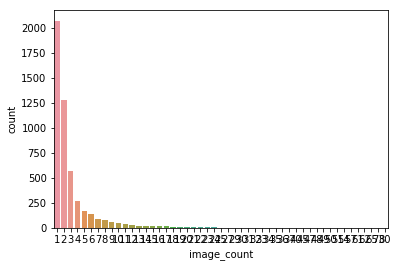

In [4]:
counted = train_df.groupby("Id").count().rename(columns={"Image":"image_count"})
counted.loc[counted["image_count"] > 80,'image_count'] = 80
plt.figure()
sns.countplot(data=counted, x="image_count")
plt.show()

### Let's see some data

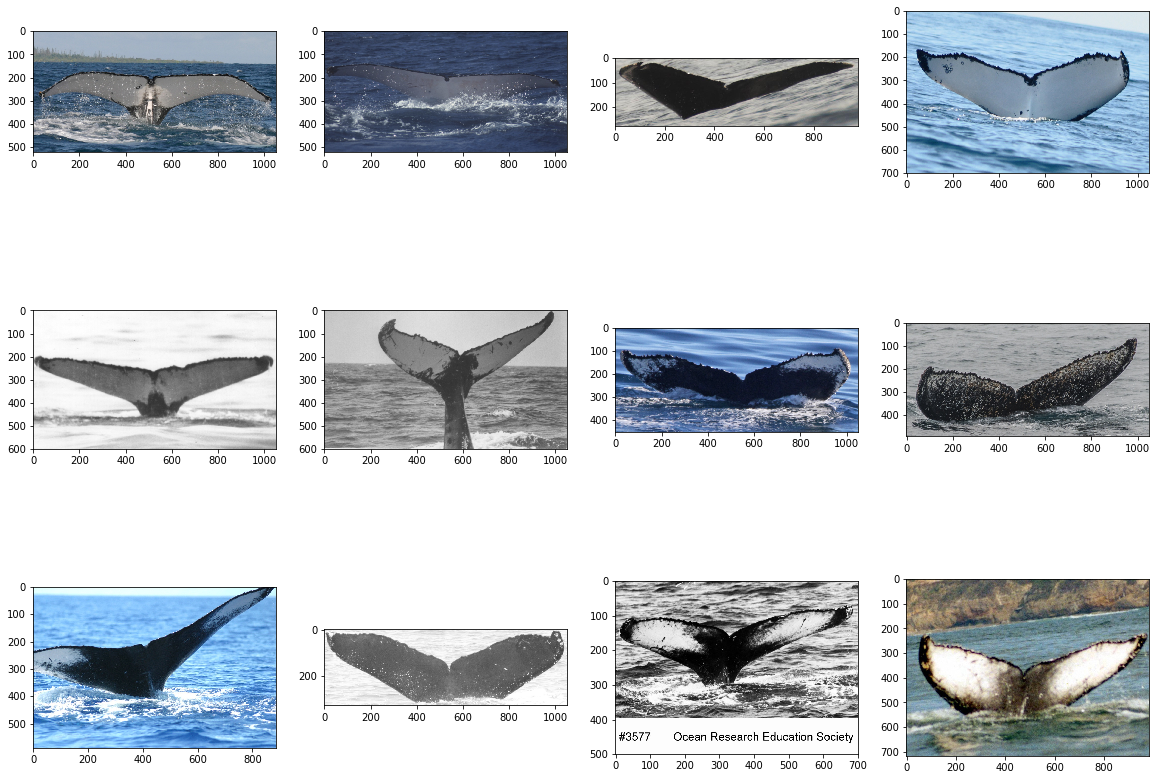

In [5]:
fig = plt.figure(figsize = (20, 15))
for idx, img_name in enumerate(train_df[train_df['Id'] == 'new_whale']['Image'][:12]):
    y = fig.add_subplot(3, 4, idx+1)
    img = cv2.imread(os.path.join(TRAIN_DIR, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    y.imshow(img)

plt.show()

### Resolutions

In [6]:
imageSizes_train = collections.Counter([Image.open(os.path.join(TRAIN_DIR, filename)).size
                        for filename in os.listdir(TRAIN_DIR)])
imageSizes_test = collections.Counter([Image.open(os.path.join(TEST_DIR, filename)).size
                        for filename in os.listdir(TEST_DIR)])

In [7]:
def isdf(imageSizes):
    imageSizeFrame = pd.DataFrame(list(imageSizes.most_common()),columns = ["imageDim","count"])
    imageSizeFrame['fraction'] = imageSizeFrame['count'] / sum(imageSizes.values())
    imageSizeFrame['count_cum'] = imageSizeFrame['count'].cumsum()
    imageSizeFrame['count_cum_fraction'] = imageSizeFrame['count_cum'] / sum(imageSizes.values())
    return imageSizeFrame

train_isdf = isdf(imageSizes_train)
train_isdf['set'] = 'train'
test_isdf = isdf(imageSizes_test)
test_isdf['set'] = 'test'

In [8]:
isizes = train_isdf.merge(test_isdf, how="outer", on="imageDim")
isizes['total_count'] = isizes['count_x'] + isizes['count_y']
dims_order = isizes.sort_values('total_count', ascending=False)[['imageDim']]
len(dims_order)

7053

In [9]:
isizes = pd.concat([train_isdf, test_isdf])

In [10]:
isizes.shape

(8150, 6)

In [11]:
isizes.head()

,imageDim,count,fraction,count_cum,count_cum_fraction,set
0,"(1050, 700)",3330,0.131304,3330,0.131304,train
1,"(1050, 600)",2549,0.100509,5879,0.231813,train
2,"(1050, 450)",1556,0.061354,7435,0.293167,train
3,"(1050, 525)",1303,0.051378,8738,0.344545,train
4,"(700, 500)",667,0.026300,9405,0.370845,train


In [12]:
popularSizes = isizes[isizes['fraction'] > 0.002]
popularSizes.shape

(39, 6)

In [13]:
popularSizes.groupby('set').max()['count_cum_fraction']

set
test     0.456030
train    0.445803
Name: count_cum_fraction, dtype: float64

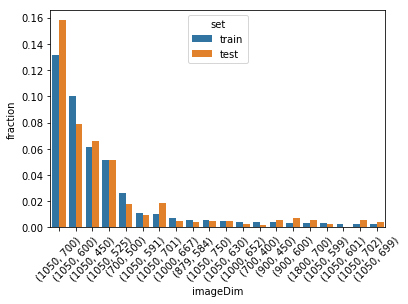

In [14]:
sns.barplot(x='imageDim',y='fraction',data = popularSizes, hue="set")
_ = plt.xticks(rotation=45)

### Prepare datasets:
- with whales with at least 4 images
- with whales with 2 or 3 images
- with whales with only one image
- with only new whales


In [15]:
train_df_new_whales = train_df[train_df['Id'] == 'new_whale']

counted = train_df.groupby("Id").count().rename(columns={"Image":"image_count"})
counted_no_new_whales = counted[counted.index != 'new_whale']
counted_with_at_least_4_images = counted_no_new_whales[counted_no_new_whales['image_count'] >= 4]
counted_with_2_and_3_images = counted_no_new_whales[counted_no_new_whales['image_count'].isin([2,3])]
counted_with_one_image = counted_no_new_whales[counted_no_new_whales['image_count'] == 1]

train_df_whales_with_only_one_image = train_df[train_df['Id'].isin(counted_with_one_image.index)]
train_df_whales_with_2_and_3_images = train_df[train_df['Id'].isin(counted_with_2_and_3_images.index)]
train_df_whales_with_at_least_4_images = train_df[train_df['Id'].isin(counted_with_at_least_4_images.index)]



In [16]:
print("Shapes of new datasets: ", train_df.shape, train_df_new_whales.shape,
      train_df_whales_with_only_one_image.shape, train_df_whales_with_2_and_3_images.shape, train_df_whales_with_at_least_4_images.shape)
if train_df.shape[0] == train_df_new_whales.shape[0] + train_df_whales_with_only_one_image.shape[0] \
    + train_df_whales_with_2_and_3_images.shape[0] + train_df_whales_with_at_least_4_images.shape[0]:
    print('Number of images is ok')

Shapes of new datasets:  (25361, 2) (9664, 2) (2073, 2) (4274, 2) (9350, 2)
Number of images is ok


In [17]:
train_df_new_whales.to_csv(os.path.join(DATA_DIR, 'all_new_whales.csv'), index=False)
train_df_whales_with_only_one_image.to_csv(os.path.join(DATA_DIR, 'all_whales_with_only_one_image.csv'), index=False)
train_df_whales_with_2_and_3_images.to_csv(os.path.join(DATA_DIR, 'all_whales_with_two_or_three_images.csv'), index=False)
train_df_whales_with_at_least_4_images.to_csv(os.path.join(DATA_DIR, 'all_whales_with_at_least_four_images.csv'), index=False)

### Prepare train and validation datasets

In [18]:
# train_df_new_whales = pd.read_csv(os.path.join(DATA_DIR, 'all_new_whales.csv'))
# train_df_whales_with_only_one_image = pd.read_csv(os.path.join(DATA_DIR, 'all_whales_with_only_one_image.csv'))
# train_df_whales_with_at_least_two_images = pd.read_csv(os.path.join(DATA_DIR, 'all_whales_with_at_least_two_images.csv'))

#### Split df with at least 4 images per whale to train and validation datset and preserve at least 2 images per whale in each

In [39]:
train_at_least_2, validation_at_least_2 = train_test_split(train_df_whales_with_at_least_4_images,
                                                           test_size=0.12,
                                                           stratify=train_df_whales_with_at_least_4_images['Id'])

#### Add whales with 2 and 3 images to train dataset

In [40]:
train_at_least_2 = pd.concat([train_at_least_2, train_df_whales_with_2_and_3_images])

In [41]:
train_at_least_2.shape, validation_at_least_2.shape


((12502, 2), (1122, 2))

#### Prepare pairs datasets

In [42]:
all_validation_pairs = []
for (image_1, id_1), (image_2, id_2) in combinations(validation_at_least_2.values, 2):
    all_validation_pairs.append((image_1, image_2, id_1 == id_2))

all_positive_validation_pairs = []
for (image_1, id_1), (image_2, id_2) in combinations(validation_at_least_2.values, 2):
    if id_1 == id_2:
        all_positive_validation_pairs.append((image_1, image_2, id_1))    
    
all_positive_train_pairs = []
for (image_1, id_1), (image_2, id_2) in combinations(train_at_least_2.values, 2):
    if id_1 == id_2:
        all_positive_train_pairs.append((image_1, image_2, id_1))

In [43]:
all_validation_pairs = pd.DataFrame(all_validation_pairs, columns=['image_1', 'image_2', 'the_same'])
all_positive_validation_pairs = pd.DataFrame(all_positive_validation_pairs, columns=['image_1', 'image_2', 'Id'])
all_positive_train_pairs = pd.DataFrame(all_positive_train_pairs, columns=['image_1', 'image_2', 'Id'])


In [44]:
all_validation_pairs.shape, all_positive_validation_pairs.shape, all_positive_train_pairs.shape

((628881, 3), (550, 3), (54293, 3))

In [45]:
all_validation_pairs.to_csv(os.path.join(DATA_DIR, 'validation_pairs.csv'), index=False)
all_positive_validation_pairs.to_csv(os.path.join(DATA_DIR, 'validation_positive_pairs.csv'), index=False)
all_positive_train_pairs.to_csv(os.path.join(DATA_DIR, 'train_positive_pairs.csv'), index=False)

In [26]:
# all_validation_pairs = pd.read_csv(os.path.join(DATA_DIR, 'validation_pairs.csv'))
# all_positive_validation_pairs = pd.read_csv(os.path.join(DATA_DIR, 'validation_positive_pairs.csv'))
# all_positive_train_pairs = pd.read_csv(os.path.join(DATA_DIR, 'train_positive_pairs.csv'))

#### Split "new_whales" to validation and train groups

In [46]:
_train_df_new_whales, validation_df_new_whales = train_test_split(train_df_new_whales,
                                                                  test_size=0.2)

#### Prepare vaidation and train datasets with all whales

In [52]:
a = train_at_least_2
b = train_df_whales_with_only_one_image
c = _train_df_new_whales

train_all = pd.concat([a,b,c])
a.shape, b.shape, c.shape


((12502, 2), (2073, 2), (7731, 2))

In [53]:
d = validation_at_least_2
e = validation_df_new_whales

validation_all = pd.concat([d, e])
d.shape, e.shape


((1122, 2), (1933, 2))

In [54]:
train_all.shape, validation_all.shape

((22306, 2), (3055, 2))

In [57]:
train_all.to_csv(os.path.join(DATA_DIR, 'train_all.csv'), index=False)
validation_all.to_csv(os.path.join(DATA_DIR, 'validation_all.csv'), index=False)
